In [1]:
import json

import numpy as np
import torch
import torch.nn as nn
import bitsandbytes as bnb

import datasets
from datasets import load_dataset, load_from_disk
from datasets.arrow_dataset import Dataset
from evaluate import load

from transformers import pipeline
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM
from transformers.pipelines.pt_utils import KeyDataset

import accelerate

from tqdm import tqdm

import matplotlib.pyplot as plt

In [148]:
judge_model_id = "meta-llama/Llama-3.2-3B-Instruct"

judge_pipe = pipeline('text-generation', model=judge_model_id, torch_dtype=torch.bfloat16)
# LLama 3.2 has multiple eos_token_id. We use the "128001"
judge_pipe.tokenizer.pad_token_id = judge_pipe.model.config.eos_token_id[0]

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
Device set to use cuda:0


In [149]:
# model_id = "meta-llama/Llama-3.2-1B"
model_id = "meta-llama/Llama-3.2-1B-Instruct"

pipe = pipeline('text-generation', model=model_id, torch_dtype=torch.bfloat16)
# LLama 3.2 has multiple eos_token_id. We use the "128001"
pipe.tokenizer.pad_token_id = pipe.model.config.eos_token_id[0]

_model = pipe.model
_tokenizer = pipe.tokenizer

Device set to use cuda:0


In [150]:
quant8_config = BitsAndBytesConfig(load_in_8bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
quant8_model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quant8_config)
quant8_pipe = pipeline('text-generation', model=quant8_model, tokenizer=_tokenizer, torch_dtype='auto')
# LLama 3.2 has multiple eos_token_id. We use the "128001"
quant8_pipe.tokenizer.pad_token_id = quant8_pipe.model.config.eos_token_id[0]

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Device set to use cuda:0


In [151]:
quant4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type='nf4')
quant4_model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quant4_config)
quant4_pipe = pipeline('text-generation', model=quant4_model, tokenizer=_tokenizer, torch_dtype='auto')
# LLama 3.2 has multiple eos_token_id. We use the "128001"
quant4_pipe.tokenizer.pad_token_id = quant4_pipe.model.config.eos_token_id[0]

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Device set to use cuda:0


In [152]:
llama_1b = sum(param.numel() * param.element_size() for param in _model.parameters()) / (1024 ** 2)
llama_1b_int8 = sum(param.numel() * param.element_size() for param in quant8_model.parameters()) /  (1024 ** 2)
llama_1b_int4 = sum(param.numel() * param.element_size() for param in quant4_model.parameters()) /  (1024 ** 2)

print(f'LLama 3.2 1B Instruct with bfloat16 uses {round(llama_1b, 2)}MB of memory')
print(f'LLama 3.2 1B Instruct with bfloat16 and int8 uses {round(llama_1b_int8, 2)}MB of memory')
print(f'LLama 3.2 1B Instruct with bfloat16 and int4 uses {round(llama_1b_int4, 2)}MB of memory')

LLama 3.2 1B Instruct with bfloat16 uses 2357.13MB of memory
LLama 3.2 1B Instruct with bfloat16 and int8 uses 1429.13MB of memory
LLama 3.2 1B Instruct with bfloat16 and int4 uses 965.13MB of memory


## TriviaQA open-ended short-form generation

In [7]:
triviqa_dataset = load_dataset('mandarjoshi/trivia_qa', 'unfiltered', split='all')

In [8]:
ds_100 = triviqa_dataset.select(range(100))

In [9]:
def get_prompt_for_question(question: str) -> list:
    """
    Get prompt in chat format. This includes a system and an user prompt.
    """
    return [
        {'role': 'system', 'content': 'You are a chatbot which answers user question in the most concise manner possible.'},
        {'role': 'user', 'content': question}
    ]

In [10]:
ds_100 = ds_100.add_column('question_prompt', column=list(map(get_prompt_for_question, ds_100['question'])))
ds_100

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer', 'question_prompt'],
    num_rows: 100
})

In [11]:
# Constrastive search sampling gives only one sample per input, so we sample it multiple times.
SAMPLING = 50

# Select as per the GPU?
MULTIPLIER = 100

# params for Constrastive Search Sampling.
pipe_kwargs = {
    'penalty_alpha': 0.6,
    'top_k': 40, # 'top_k': 4,
    'max_new_tokens': 128,
    'pad_token_id': _tokenizer.pad_token_id,
    'batch_size': 5 * MULTIPLIER
}

del MULTIPLIER

# Originally, it's right side, but huggingface throws warning. 
# "A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer."
_tokenizer.padding_side = 'left'


generations = {
    'bfloat16': [],
    'int8': [],
    'int4': []
}

# inference_ds = KeyDataset(ds_100.repeat(SAMPLING), key='question')
inference_ds = KeyDataset(ds_100.repeat(SAMPLING), key='question_prompt')
n = len(inference_ds)

with tqdm(total=n, desc='bfloat16') as pbar:
    for out in pipe(inference_ds, **pipe_kwargs):
        generations['bfloat16'].append(out[0]['generated_text'])

        pbar.update()

with tqdm(total=n, desc='int8') as pbar:
    for out in quant8_pipe(inference_ds, **pipe_kwargs):
        generations['int8'].append(out[0]['generated_text'])

        pbar.update()

with tqdm(total=n, desc='int4') as pbar:
    for out in quant4_pipe(inference_ds, **pipe_kwargs):
        generations['int4'].append(out[0]['generated_text'])

        pbar.update()


torch.cuda.empty_cache()

int4: 100%|██████████| 5000/5000 [01:34<00:00, 52.79it/s] 


In [26]:
def get_prompt_for_verification(question: str, answer: dict, chat_history: list) -> list:
    """
    Get prompt in chat format. This includes a system and an user prompt.
    """
    normalized_value = answer['normalized_value']
    response = chat_history[-1]['content']
    
    return [
        {'role': 'system', 'content': 'For the following query give response as True or False, nothing more.'}, # , nothing more
        # {'role': 'user', 'content': f'For the question "{ds_100[0]['question']}", the correct answer is "{ds_100[0]['answer']['normalized_value']}". Does the response "{responses[0]['generated_text'][-1]['content']} the time was Harry Truman" the correct answer?'}
        # {'role': 'user', 'content': f'Does "{ds_100[0]['answer']['normalized_value']}" appears in the following text "{responses[0]['generated_text'][-1]['content']}"'}
        {'role': 'user', 'content': f'For the question "{question}", the correct answer is "{normalized_value}". Does the response "{response}" fits the correct answer?'}
    ]

In [27]:
ds_100_generations = ds_100.repeat(SAMPLING)

for key, value in generations.items():
    name = f'{key}_response'
    ds_100_generations = ds_100_generations.add_column(name, value)
    ds_100_generations = ds_100_generations.add_column(f'{key}_verification_prompt', column=list(map(get_prompt_for_verification, 
                                                                                                       ds_100_generations['question'], 
                                                                                                       ds_100_generations['answer'],
                                                                                                       ds_100_generations[name])))

ds_100_generations

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer', 'question_prompt', 'bfloat16_response', 'bfloat16_verification_prompt', 'int8_response', 'int8_verification_prompt', 'int4_response', 'int4_verification_prompt'],
    num_rows: 5000
})

## Evaluating responses on "Correctness" as seen by a judge model.

In [31]:
# Select as per the GPU?
MULTIPLIER = 35

# params for Judge, no specific sampling methodology. LLama 3.2 3B follows the instructions quite well.
verification_pipe_kwargs = {
    # 'penalty_alpha': 0.6,
    # 'top_k': 40, # 'top_k': 4,
    # 'max_new_tokens': 128,
    'pad_token_id': _tokenizer.pad_token_id,
    'batch_size': 5 * MULTIPLIER
}

del MULTIPLIER

# Originally, it's right side, but huggingface throws warning. 
# "A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer."
# _tokenizer.padding_side = 'left'
judge_pipe.tokenizer.padding_side = 'left'

verifications = {
    'bfloat16': [],
    'int8': [],
    'int4': []
}

torch.cuda.empty_cache()

# We ask the judge multiple times and accumulate "True" or "False".
VERIFICATION_SAMPLES = 25
# VERIFICATION_SAMPLES = 10


for key in verifications.keys():
    verification_ds = KeyDataset(ds_100_generations.repeat(VERIFICATION_SAMPLES), key=f'{key}_verification_prompt')
    n = len(verification_ds)

    with tqdm(total=n, desc=f'{key}_verification') as pbar:
        for out in judge_pipe(verification_ds, **verification_pipe_kwargs):
            verifications[key].append(out[0]['generated_text'])

            pbar.update()

    torch.cuda.empty_cache()

# with tqdm(total=n, desc='bfloat16') as pbar:
#     for out in pipe(verification_ds, **pipe_kwargs):
#         generations['bfloat16'].append(out[0]['generated_text'])

#         pbar.update()

# with tqdm(total=n, desc='int8') as pbar:
#     for out in quant8_pipe(verification_ds, **pipe_kwargs):
#         generations['int8'].append(out[0]['generated_text'])

#         pbar.update()

# with tqdm(total=n, desc='int4') as pbar:
#     for out in quant4_pipe(verification_ds, **pipe_kwargs):
#         generations['int4'].append(out[0]['generated_text'])

#         pbar.update()


# torch.cuda.empty_cache()

int4_verification: 100%|██████████| 125000/125000 [23:16<00:00, 89.52it/s]   


In [29]:
generations['bfloat16'][0]

[{'content': 'You are a chatbot which answers user question in the most concise manner possible.',
  'role': 'system'},
 {'content': 'Who was President when the first Peanuts cartoon was published?',
  'role': 'user'},
 {'role': 'assistant',
  'content': 'The first Peanuts cartoon was published in 1950. The President at that time was Harry S. Truman.'}]

In [66]:
ds_100_verifications_25 = ds_100_generations.repeat(VERIFICATION_SAMPLES)

for key, value in verifications.items():
    name = f'{key}_verification_response'
    ds_100_verifications_25 = ds_100_verifications_25.add_column(name, value)

ds_100_generations.save_to_disk('ds_100_slice')
ds_100_verifications_25.save_to_disk('ds_100_verifications_25_slice')

Saving the dataset (51/51 shards): 100%|██████████| 125000/125000 [00:11<00:00, 11003.23 examples/s]


In [2]:
ds_100_generations = load_from_disk('ds_100_slice')
ds_100_verifications_25 = load_from_disk('ds_100_verifications_25_slice')

Loading dataset from disk:   0%|          | 0/51 [00:00<?, ?it/s]

### Resample from tile to repeat (numpy style tile and repeat).
example -> [1, 2, 3, 1, 2, 3] to [1, 1, 2, 2, 3, 3]

In [ ]:
for verification_key in ('bfloat16', 'int8', 'int4'): 
    verification_key = f'{verification_key}_verification_response'
    arr = np.array([int(chat[-1]['content'].lower() == 'true') for chat in ds_100_verifications_25[verification_key]])
    
    # The first two dims are ordered following FIFO strategy to 
    # balance the 'tile' operations applied on the original 100 questions.
    arr = arr.reshape(VERIFICATION_SAMPLES, SAMPLING, -1)
    # We average the results over each verification for each sample.
    mean_accuracy_per_sample : np.ndarray = arr.mean(axis=0)
    # We then average and std over each sample for each question.
    accuracy_per_question : np.ndarray = mean_accuracy_per_sample.mean(axis=0)
    std_per_question : np.ndarray = mean_accuracy_per_sample.std(axis=0)

    mean_accuracy = accuracy_per_question.mean(axis=0)
    avg_std = std_per_question.mean(axis=0)

    print(mean_accuracy, avg_std, arr.mean(), arr.std())

0.20784000000000002 0.12627533417736614 0.20784 0.40576167192084567
0.21407199999999998 0.13406511308598099 0.214072 0.4101770091265477
0.124848 0.11362938126518925 0.124848 0.33054648220182287


In [146]:
coqa_dataset = load_dataset('stanfordnlp/coqa', split='all')

In [147]:
coqa_dataset

Dataset({
    features: ['source', 'story', 'questions', 'answers'],
    num_rows: 7699
})

In [145]:
idx = 0

print(coqa_dataset[idx]['story'])
print('*' * 200)
print(coqa_dataset[idx]['questions'])
print('*' * 200)
print(coqa_dataset[idx]['answers']['input_text'])
print('*' * 200)

Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a nice warm place above the barn where all of the farmer's horses slept. But Cotton wasn't alone in her little home above the barn, oh no. She shared her hay bed with her mommy and 5 other sisters. All of her sisters were cute and fluffy, like Cotton. But she was the only white one in the bunch. The rest of her sisters were all orange with beautiful white tiger stripes like Cotton's mommy. Being different made Cotton quite sad. She often wished she looked like the rest of her family. So one day, when Cotton found a can of the old farmer's orange paint, she used it to paint herself like them. When her mommy and sisters found her they started laughing. 

"What are you doing, Cotton?!" 

"I only wanted to be more like you". 

Cotton's mommy rubbed her face on Cotton's and said "Oh Cotton, but your fur is so pretty and special, like you. We would never want you to be any o

In [138]:
len(coqa_dataset)

7699

In [137]:
print(len(coqa_dataset[0]['questions']))
print(len(coqa_dataset[0]['answers']['input_text']))

20
20


In [ ]:
coqa_dataset[0]['story']

In [153]:
def get_prompt_for_coqa_question(context: str, question: str) -> list:
    """
    Get prompt for CoQA in chat format. This includes a system and an user prompt.
    """
    return [
        {'role': 'system', 'content': f'You are a chatbot which answers user question in the most concise manner possible from given context, "{context}"'},
        {'role': 'user', 'content': question}
    ]

In [155]:
get_prompt_for_coqa_question(coqa_dataset[0]['story'], coqa_dataset[0]['questions'][0])

[{'role': 'system',
  'content': 'You are a chatbot which answers user question in the most concise manner possible from given context, "The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. \n\nThe Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. \n\nIn March 2014, the Vatican Library began an initial four-year project of digitising its colle

In [158]:
coqa_dataset[0]['answers']['input_text'][0]

'It was formally established in 1475'

In [159]:
pipe_kwargs = {
    'penalty_alpha': 0.6,
    'top_k': 40, # 'top_k': 4,
    'max_new_tokens': 128,
    'pad_token_id': _tokenizer.pad_token_id,
    # 'batch_size': 5 * MULTIPLIER
}

pipe(get_prompt_for_coqa_question(coqa_dataset[0]['story'], coqa_dataset[0]['questions'][0]), pad_token_id= _tokenizer.pad_token_id)

[{'generated_text': [{'role': 'system',
    'content': 'You are a chatbot which answers user question in the most concise manner possible from given context, "The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. \n\nThe Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. \n\nIn March 2014, the Vatican Library began an initial four-year project o

In [65]:
final_accuracy = 0.0

for sample_question_idx in range(SAMPLING):
    accuracy = 0.0

    # Idx from the 50 * 100 questions.
    # starting_idx = 1 + 100 * 49
    original_question_idx = 0 
    # sample_question_idx = 1
    starting_idx = original_question_idx + 100 * sample_question_idx
    for idx in range(starting_idx, n, len(ds_100_generations)):
        item = verifications['bfloat16'][idx]
        # print(item)
        accuracy += int(item[-1]['content'].lower() == 'true')

    # print('*' * 15)
    # print(f'Accuracy is {(accuracy / count):.3f}%')
    final_accuracy += accuracy / VERIFICATION_SAMPLES

print(f'Accuracy is {(final_accuracy / SAMPLING):.3f}%')

Accuracy is 0.513%


In [41]:
len(range(starting_idx, n, len(ds_100_generations)))

25

In [32]:
verifications['bfloat16'][0]

[{'content': 'For the following query give response as True or False, nothing more.',
  'role': 'system'},
 {'content': 'For the question "Who was President when the first Peanuts cartoon was published?", the correct answer is "harry truman". Does the response "The first Peanuts cartoon was published in 1950. The President at that time was Harry S. Truman." fits the correct answer?',
  'role': 'user'},
 {'role': 'assistant', 'content': 'False'}]

In [84]:
def verify_response_via_judge_model(ds: Dataset, idx: int, verification_samples: int = 25) -> list:
    row = ds[idx]
    question = row['question']
    normalized_answer = row['answer']['normalized_value']

    response_types = ['bfloat16_response', 'int8_response', 'int4_response']

    response_accuracies = []

    for key in response_types:
        response = row[key]
        # response = row[key].removeprefix(question)
        # print(f'Question: {question}')
        # print(f'Response: {response}')

        response_item = [
            {'role': 'system', 'content': 'For the following query give response as True or False, nothing more.'},
            # {'role': 'user', 'content': f'Does "{ds_100[0]['answer']['normalized_value']}" appears in the following text "{responses[0]['generated_text'][-1]['content']}"'}
            {'role': 'user', 'content': f'For the question "{question}", the correct answer is "{normalized_answer}". Does the response "{response}" fits the correct answer?'}
        ]

        verification_responses = judge_pipe([response_item] * verification_samples, pad_token_id = _tokenizer.pad_token_id)

        print(json.dumps(verification_responses, indent=4))

        accuracy_score = sum(int(veri_response[0]['generated_text'][-1]['content'].lower() == 'true') for veri_response in verification_responses) / verification_samples
        response_accuracies.append(accuracy_score)

    return response_accuracies

In [86]:
verify_response_via_judge_model(ds_100_generations, idx=1)

[
    [
        {
            "generated_text": [
                {
                    "role": "system",
                    "content": "For the following query give response as True or False, nothing more."
                },
                {
                    "role": "user",
                    "content": "For the question \"Which American-born Sinclair won the Nobel Prize for Literature in 1930?\", the correct answer is \"sinclair lewis\". Does the response \"Which American-born Sinclair won the Nobel Prize for Literature in 1930? Sinclair Lewis\n\n## Step 1: Identify the American-born author mentioned in the problem.\nThe problem mentions an American-born author.\n\n## Step 2: Recall the list of authors who have won the Nobel Prize for Literature.\nThe list of authors who have won the Nobel Prize for Literature includes past winners such as William Faulkner, Ernest Hemingway, John Steinbeck, Gabriel Garcia Marquez, and Toni Morrison, among others.\n\n## Step 3: Identify the cor

[0.0, 0.32, 0.0]

## Too slow

In [68]:
generation_accuracies = {
    'bfloat16': [],
    'int8': [],
    'int4': []
}

for idx in tqdm(range(len(ds_100_generations))):
    response_accuracies = verify_response_via_judge_model(ds_100_generations, idx=idx)
    generation_accuracies['bfloat16'].append(response_accuracies[0])
    generation_accuracies['int8'].append(response_accuracies[1])
    generation_accuracies['int4'].append(response_accuracies[2])

torch.cuda.empty_cache()

  1%|▏         | 68/5000 [03:09<3:49:19,  2.79s/it]


KeyboardInterrupt: 

## Loading Bert Score metric

In [10]:
bert_score_metric = load('bertscore')

#### We choose the best F1 score from the TriviaQA dataset for each sample.
So, we repeat the responses to match the references for the bert score metric calculation.

In [12]:
possible_answers_count = [len(item['normalized_aliases']) for item in ds_100_generations['answer']]
ds_100_generations = ds_100_generations.add_column('repeat_samples_count', possible_answers_count)

# ds_100_generations.save_to_disk('ds_100_slice')

ds_100_generations

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer', 'bfloat16_response', 'int8_response', 'int4_response', 'repeat_samples_count'],
    num_rows: 5000
})

In [17]:
ds_100_generations = load_from_disk('ds_100_slice')

### A possible problem with BERTScore???

In [15]:
bert_score_entries = []

for item in ds_100_generations.select_columns(['question', 'answer', 'bfloat16_response', 'int8_response', 'int4_response', 'repeat_samples_count']):
    prefix = item['question']
    repeat_count = item['repeat_samples_count']
    bfloat16_response = item['bfloat16_response']
    normalized_ground_truth = item['answer']['normalized_aliases']
    
    bfloat16_scores = bert_score_metric.compute(predictions=[bfloat16_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en')
    print(bfloat16_response.removeprefix(prefix))
    print(normalized_ground_truth)
    print(bfloat16_scores['f1'])
    break

 Harry Truman
When the first Peanuts cartoon was published in 1950, President Harry Truman was in office.
The cartoon was created by Charles M. Schulz and was first published in the Washington Post on October 2, 1950. It was later syndicated and became a huge success. The cartoon was originally called "Li'l Folks" and was later renamed "Peanuts." It was known for its humorous and relatable portrayal of everyday life and its characters, including Charlie Brown, Snoopy, Lucy, and Linus. The cartoon was a huge success and became a cultural phenomenon, running for over 50
['presidency of harry s truman', '33rd president of united states', 'truman administration', 's truman', 'mr citizen', 'harry truman s', 'harry truman', 'hary truman', 'harry shipp truman', 'h truman', 'harry shippe truman', 'h s truman', 'president truman', 'president harry truman', 'hst president', 'presidency of harry truman', 'mary jane truman', 'harry solomon truman', 'harold truman', 'harry s truman']
[0.78310155868

In [18]:
prediction = """
 Harry Truman
When the first Peanuts cartoon was published in 1950, President Harry Truman was in office.
The cartoon was created by Charles M. Schulz and was first published in the Washington Post on October 2, 1950. It was later syndicated and became a huge success. The cartoon was originally called "Li'l Folks" and was later renamed "Peanuts." It was known for its humorous and relatable portrayal of everyday life and its characters, including Charlie Brown, Snoopy, Lucy, and Linus. The cartoon was a huge success and became a cultural phenomenon, running for over 50
"""
print(prediction)


 Harry Truman
When the first Peanuts cartoon was published in 1950, President Harry Truman was in office.
The cartoon was created by Charles M. Schulz and was first published in the Washington Post on October 2, 1950. It was later syndicated and became a huge success. The cartoon was originally called "Li'l Folks" and was later renamed "Peanuts." It was known for its humorous and relatable portrayal of everyday life and its characters, including Charlie Brown, Snoopy, Lucy, and Linus. The cartoon was a huge success and became a cultural phenomenon, running for over 50



In [16]:
value = ds_100_generations['answer'][0]['value']
print(value)

Harry Truman


In [19]:
bert_score_metric.compute(predictions=[prediction], references=[ds_100_generations['answer'][0]['value']], lang='en')

{'precision': [0.7731977701187134],
 'recall': [0.909644603729248],
 'f1': [0.8358895182609558],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.49.0)'}

In [20]:
bert_score_entries = []
batch_size = max(ds_100_generations['repeat_samples_count'])

with tqdm(total=n, desc='Calculating BERT Score') as pbar:
    for item in ds_100_generations.select_columns(['question', 'answer', 'bfloat16_response', 'int8_response', 'int4_response', 'repeat_samples_count']):
        prefix = item['question']
        repeat_count = item['repeat_samples_count']
        bfloat16_response = item['bfloat16_response']
        int8_response = item['int8_response']
        int4_response = item['int4_response']
        normalized_ground_truth = item['answer']['normalized_aliases']
        # repeat_count = len(normalized_ground_truth)

        # wrt normalized ground truth.
        
        bfloat16_scores = bert_score_metric.compute(predictions=[bfloat16_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en', batch_size=batch_size)
        int8_scores = bert_score_metric.compute(predictions=[int8_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en', batch_size=batch_size)
        int4_scores = bert_score_metric.compute(predictions=[int4_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en', batch_size=batch_size)

        entry = {
            'bfloat16': max(zip(bfloat16_scores['f1'], normalized_ground_truth)),
            'int8': max(zip(int8_scores['f1'], normalized_ground_truth)),
            'int4': max(zip(int4_scores['f1'], normalized_ground_truth))
        }

        bert_score_entries.append(entry)
        pbar.update()

Calculating BERT Score: 100%|██████████| 5000/5000 [07:36<00:00, 10.95it/s]


In [22]:
bfloat16_avg = sum([entry['bfloat16'][0] for entry in bert_score_entries]) / len(bert_score_entries)
int8_avg = sum([entry['int8'][0] for entry in bert_score_entries]) / len(bert_score_entries)
int4_avg = sum([entry['int4'][0] for entry in bert_score_entries]) / len(bert_score_entries)

print(f'Following are the results:\nbfloat16: {bfloat16_avg}\nint8: {int8_avg}\nint4: {int4_avg}')

Following are the results:
bfloat16: 0.7982039891600609
int8: 0.7989459544658661
int4: 0.7973123145699501


In [23]:
bert_score_kwargs = {
    'batch_size': 200
}

predictions_int8 = [response.removeprefix(question) for response, question in zip(ds_100_generations['int8_response'], ds_100_generations['question'])]
predictions_int4 = [response.removeprefix(question) for response, question in zip(ds_100_generations['int4_response'], ds_100_generations['question'])]
references_bfloat16 = [response.removeprefix(question) for response, question in zip(ds_100_generations['bfloat16_response'], ds_100_generations['question'])]

int8_to_bfloat16_scores = bert_score_metric.compute(predictions=predictions_int8, references=references_bfloat16, lang='en', **bert_score_kwargs)
int4_to_bfloat16_scores = bert_score_metric.compute(predictions=predictions_int4, references=references_bfloat16, lang='en', **bert_score_kwargs)

avg_int8_bfloat16 = sum(int8_to_bfloat16_scores['f1']) / len(int8_to_bfloat16_scores['f1'])
avg_int4_bfloat16 = sum(int4_to_bfloat16_scores['f1']) / len(int4_to_bfloat16_scores['f1'])

print(avg_int8_bfloat16)
print(avg_int4_bfloat16)

0.8617744245886803
0.8585900864005089


In [24]:
# bert_score_entries = []

accumulated_predictions = {
    'bfloat16': [],
    'int8': [],
    'int4': [],
    'ground_truth': []
}

for item in ds_100_generations.select_columns(['question', 'answer', 'bfloat16_response', 'int8_response', 'int4_response', 'repeat_samples_count']):
    prefix = item['question']
    repeat_count = item['repeat_samples_count']
    bfloat16_response = item['bfloat16_response']
    int8_response = item['int8_response']
    int4_response = item['int4_response']
    normalized_ground_truth = item['answer']['normalized_aliases']
    ground_truth = item['answer']['value']
    # repeat_count = len(normalized_ground_truth)

    # wrt normalized ground truth.

    # accumulated_predictions['bfloat16'].extend([bfloat16_response.removeprefix(prefix)] * repeat_count)
    # accumulated_predictions['int8'].extend([int8_response.removeprefix(prefix)] * repeat_count)
    # accumulated_predictions['int4'].extend([int4_response.removeprefix(prefix)] * repeat_count)
    # accumulated_predictions['ground_truth'].extend(normalized_ground_truth)

    accumulated_predictions['bfloat16'].append(bfloat16_response.removeprefix(prefix))
    accumulated_predictions['int8'].append(int8_response.removeprefix(prefix))
    accumulated_predictions['int4'].append(int4_response.removeprefix(prefix))
    # accumulated_predictions['ground_truth'].append(' '.join(normalized_ground_truth))
    accumulated_predictions['ground_truth'].append(ground_truth)

bert_score_kwargs = {
    'batch_size': 200
}

bfloat16_scores = bert_score_metric.compute(predictions=accumulated_predictions['bfloat16'], references=accumulated_predictions['ground_truth'], lang='en', **bert_score_kwargs)
int8_scores = bert_score_metric.compute(predictions=accumulated_predictions['int8'], references=accumulated_predictions['ground_truth'], lang='en', **bert_score_kwargs)
int4_scores = bert_score_metric.compute(predictions=accumulated_predictions['int4'], references=accumulated_predictions['ground_truth'], lang='en', **bert_score_kwargs)
    
# bfloat16_scores = bert_score_metric.compute(predictions=[bfloat16_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en')
# int8_scores = bert_score_metric.compute(predictions=[int8_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en')
# int4_scores = bert_score_metric.compute(predictions=[int4_response.removeprefix(prefix)] * repeat_count, references=normalized_ground_truth, lang='en')

avg_bfloat16_scores = sum(bfloat16_scores['f1']) / len(bfloat16_scores['f1'])
avg_int8_scores = sum(int8_scores['f1']) / len(int8_scores['f1'])
avg_int4_scores = sum(int4_scores['f1']) / len(int4_scores['f1'])

print(avg_bfloat16_scores)
print(avg_int8_scores)
print(avg_int4_scores)

# entry = {
#     'bfloat16': max(zip(bfloat16_scores['f1'], normalized_ground_truth)),
#     'int8': max(zip(int8_scores['f1'], normalized_ground_truth)),
#     'int4': max(zip(int4_scores['f1'], normalized_ground_truth))
# }

# bert_score_entries.append(entry)

    # Wrt bfloat16

    # int8_to_bfloat16_scores = bert_score_metric.compute(predictions=[int8_response], references=[bfloat16_response], lang='en')

    # print(int8_to_bfloat16_scores['f1'])

0.7932211196541786
0.7939153614163399
0.7909700437068939


In [20]:
scores = bert_score_metric.compute(predictions=['harry truman'] * 20, references=triviqa_dataset[0]['answer']['normalized_aliases'], lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
bert_score_metric.compute(predictions=['harry truman'], references=[' '.join(triviqa_dataset[0]['answer']['normalized_aliases'])], lang='en')

{'precision': [0.8335356116294861],
 'recall': [0.7481536865234375],
 'f1': [0.7885401248931885],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.49.0)'}

In [21]:
scores['f1']

[0.8932179808616638,
 0.7593820095062256,
 0.8547483682632446,
 0.9411242008209229,
 0.7692710161209106,
 0.9693154692649841,
 1.0,
 0.941097617149353,
 0.9302520155906677,
 0.9214673638343811,
 0.9041468501091003,
 0.870368480682373,
 0.9432796835899353,
 0.9292186498641968,
 0.7604589462280273,
 0.9056100845336914,
 0.8884554505348206,
 0.933370053768158,
 0.9273219704627991,
 0.9495211839675903]

In [46]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [47]:
modernBERT_similarity_id = 'joe32140/ModernBERT-large-msmarco'

In [57]:
bfloat16_responses = ds_100_generations['bfloat16_response'][:10]
ground_truth = [item['value'] for item in ds_100_generations['answer'][:10]]

In [59]:
bfloat16_responses

['Who was President when the first Peanuts cartoon was published? Lyndon B. Johnson?\nNo, that is incorrect. The first Peanuts cartoon was published in 1950. Lyndon B. Johnson was the 36th President of the United States, and he was in office from 1963 to 1969.\n\nThe first Peanuts cartoon was published on October 2, 1950. It was created by Charles M. Schulz and was initially titled "Li\'l Folks." It was later renamed Peanuts. The first Peanuts cartoon was published in the Saturday Evening Post. It was a simple comic strip with simple, yet humorous characters. The strip was created by Charles',
 'Which American-born Sinclair won the Nobel Prize for Literature in 1930? Sinclair Lewis, an American novelist, was awarded the Nobel Prize in Literature for his contributions to the art of the novel.\n\nSinclair Lewis was born on July 30, 1885, in Williston, Vermont. Lewis was a prominent figure in American literature, known for his novels that often explored the complexities of human nature an

In [82]:
from sentence_transformers import SentenceTransformer

In [83]:
model = SentenceTransformer(modernBERT_similarity_id)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/204 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/51.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [85]:
bfloat16_responses_embeddings = model.encode(bfloat16_responses)
ground_truth_embeddings = model.encode(ground_truth)

In [87]:
simalrity_matrtix = model.similarity(bfloat16_responses_embeddings, ground_truth_embeddings)

In [110]:
simalrity_matrtix.argmax(dim=-1)

tensor([0, 1, 2, 3, 8, 3, 6, 5, 8, 6])

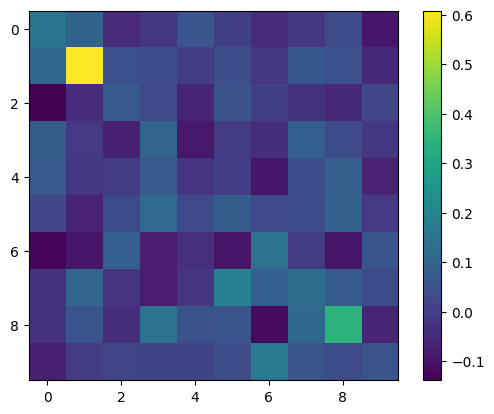

In [112]:
plt.imshow(simalrity_matrtix)
plt.colorbar()

### Problem with similarity-based metrics

In [122]:
spuriously_correct = (simalrity_matrtix.argmax(dim=-1) == torch.arange(simalrity_matrtix.size(dim=0))).tolist()
print(*zip(spuriously_correct, ground_truth, bfloat16_responses), sep='\n')

(True, 'Harry Truman', 'Who was President when the first Peanuts cartoon was published? Lyndon B. Johnson?\nNo, that is incorrect. The first Peanuts cartoon was published in 1950. Lyndon B. Johnson was the 36th President of the United States, and he was in office from 1963 to 1969.\n\nThe first Peanuts cartoon was published on October 2, 1950. It was created by Charles M. Schulz and was initially titled "Li\'l Folks." It was later renamed Peanuts. The first Peanuts cartoon was published in the Saturday Evening Post. It was a simple comic strip with simple, yet humorous characters. The strip was created by Charles')
(True, 'Sinclair Lewis', 'Which American-born Sinclair won the Nobel Prize for Literature in 1930? Sinclair Lewis, an American novelist, was awarded the Nobel Prize in Literature for his contributions to the art of the novel.\n\nSinclair Lewis was born on July 30, 1885, in Williston, Vermont. Lewis was a prominent figure in American literature, known for his novels that ofte